![DeepNeuro](https://github.com/QTIM-Lab/DeepNeuro/raw/master/package_resources/logos/DeepNeuro_alt.PNG?raw=true)

# Running Inference on a Model, and Calculating Test Statistics

In previous tutorials, we showed you how to load, preprocess, augment, and train neural networks on medical imaging data. In this tutorial, we are going to show you how to run inference on a fully-trained tumor segmentation network, add post-processing steps to that network, and evaluate our results according to a few different metrics.

## Loading Data

We will start by loading some data to test on, using DeepNeuro's DataCollection object. If you don't know what's going on in this code, I suggest that you check out the DeepNeuro tutorial on loading, preprocessing, and augmenting input data.

Unlike previous tutorials, we won't write our data to HDF5 this time. We don't need to do any computationally-intensive preprocessing this time around, and we won't need to augment and shuffle our datasets in advance.

In [1]:
# !pip install deepneuro

import deepneuro
from deepneuro.load import load

# If you haven't downloaded the data from the previous tutorials,
# you can do so here.
load('sample_gbm_nifti', output_datapath='./Sample_Data')

'./Sample_Data/TCGA_GBM_NIFTI.zip'

The model we are working with in this tutorial is slightly different than the previous tutorials. It takes in two sequences, FLAIR and post-contrast T1, and produces only one binary segmentation map of the whole area demarcated by edematous tissue, enhancing tumor, and necrosis. Some of the preprocessing we do in the steps below is thus different from the preprocessing we did in the previous tutorial, particularly when specifying testing_data_sources and when using the SplitData preprocessor.

Using TensorFlow backend.


('Found', 1, 'cases..')


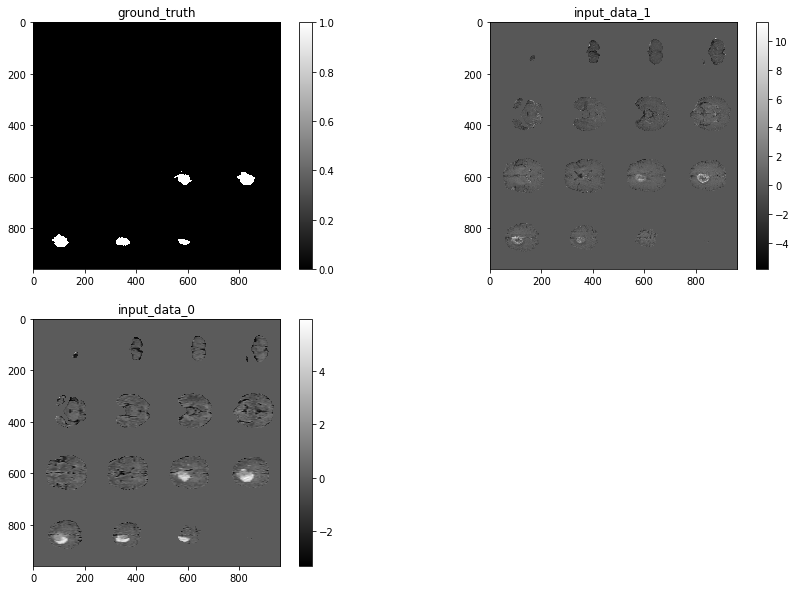

In [2]:
# Some code to making plotting in Juypter/Colab Notebooks work correctly.
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

import os

from deepneuro.utilities import check_data

# If your workstation has multiple GPUs, this code will make sure
# you only use GPU #0 in this Jupyter notebook.
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

from deepneuro.data import DataCollection
from deepneuro.preprocessing import ZeroMeanNormalization, SplitData

testing_data_sources = {
    'directories': {
                'Sample_Data/GBM_NIFTI/TESTING':
                {'input_data': ['*_flair.nii.gz*', '*_t1Gd.nii.gz'], 
                 'ground_truth': ['*GlistrBoost_ManuallyCorrected.nii.gz']}},
}

# If you're lacking on space, you can turn down the patch_multiplier variable.
def load_preprocess_augment(data_sources):
    
    data_collection = DataCollection(data_sources=data_sources)

    normalization_preprocessor = ZeroMeanNormalization(data_groups=['input_data'],
                                                   normalize_by_channel=True, 
                                                   mask_zeros=True,
                                                   verbose=False)
    one_hot_preprocessor = SplitData(data_groups=['ground_truth'], 
                                     label_splits=[[1,2,4]],
                                     verbose=False)
    data_collection.append_preprocessor([normalization_preprocessor, one_hot_preprocessor])

    return data_collection

testing_data = load_preprocess_augment(testing_data_sources)
figure = check_data(data_collection=testing_data, batch_size=1, viz_mode_3d='mosaic', data_groups='input_data')

Looks pretty good! The ground_truth is a binary label specifying the location of the tumor, input_data_0 is the FLAIR sequence, and input_data_1 in the post-contrast T1 sequence.

## Loading an Old Model

The first step is to load a trained model. You can load one that you have trained previously here, or download a pretrained whole tumor area segmenter from DeepNeuro.

In [3]:
from deepneuro.models import load_old_model

load('gbm_wholetumor_mri', output_datapath='./Sample_Models')

pretrained_model = load_old_model('./Sample_Models/Segment_GBM_Wholetumor_Model.h5')

## Performing Patchwise Inference

Most 3D neural networks for segmentation process only a subset of a given MR scan a time, referred to as a "patch." This creates an additional computational challenge when performing inference: we have to take input MRs of potentially variable size, split them into patches, predict segmentations for each of those patches, and restitch those images into a complete whole. Furthermore, one may want to predict series of overlapping patches, to mitigate the effect of individual errors on any given patch.

Luckily for us, DeepNeuro can do all that automatically! To do that, we will create a ModelPatchesInference object.

('Working on image.. ', 0, 'at', '/home/abeers/Github/DeepNeuro/notebooks/Sample_Data/GBM_NIFTI/TESTING/TCGA-12-1094')
('Predicting patch set', '1/1...')


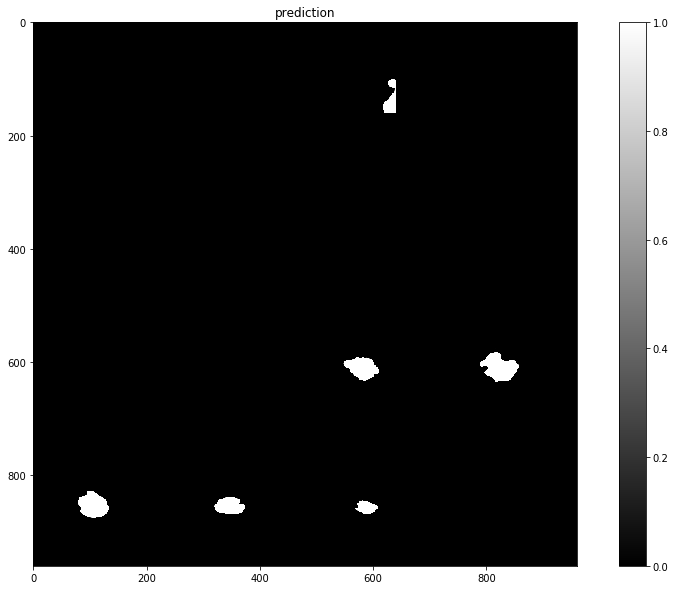

In [4]:
from deepneuro.outputs import PatchesInference

testing_parameters = {'inputs': ['input_data'],
               'output_filename': '_seg_predict.nii.gz',
               'batch_size': 20,
               'output_patch_shape': (64, 64, 8, 1),
               'patch_overlaps': 1,
               'output_directory': './Inference_Results',
               'show_output': True,
               'viz_mode_3d': 'mosaic'}

prediction = PatchesInference(**testing_parameters)

pretrained_model.clear_outputs()
pretrained_model.append_output([prediction])

figure = pretrained_model.generate_outputs(testing_data)

Judging from the slice-mosaic above, we might have something close to the ground-truth we visualized in the earlier tutorial! However, there is that area that is erroneously segmented in the top row. This could be for any number of reasons. Perhaps our model did not converge, or the test set differed from our training set. It is hard to know without further investigation.

We do we have a way, however, to improve our models' performance in the face of such errors. This can be achieved by 'overlapping' the patches we predict. Each patch one chooses to predict on will have unique characteristics, and some of these characteristics may lead to prediction errors that a patch right next to it might have ignored. If we predict multiple patches for every voxel in our original volume, and then average the results, the performance may improve. One can think of this as a form of 'ensembling' for patch prediction -- when in doubt, defer to the majority.

There is a trade-off here, of course. Predicting more overlapping patches leads to linearly-increasing inference times. Predicting a patch centered on every voxel would be computationally impractical, so we have to strike a balance.

In the code below, we change our patch prediction method to have 8 "patch overlaps" to see if it can solve our error. In practical terms, this means that each voxel in our original volume is covered by predictions from at least 8 different patches.

('Working on image.. ', 0, 'at', '/home/abeers/Github/DeepNeuro/notebooks/Sample_Data/GBM_NIFTI/TESTING/TCGA-12-1094')
('Predicting patch set', '1/8...')
('Predicting patch set', '2/8...')
('Predicting patch set', '3/8...')
('Predicting patch set', '4/8...')
('Predicting patch set', '5/8...')
('Predicting patch set', '6/8...')
('Predicting patch set', '7/8...')
('Predicting patch set', '8/8...')


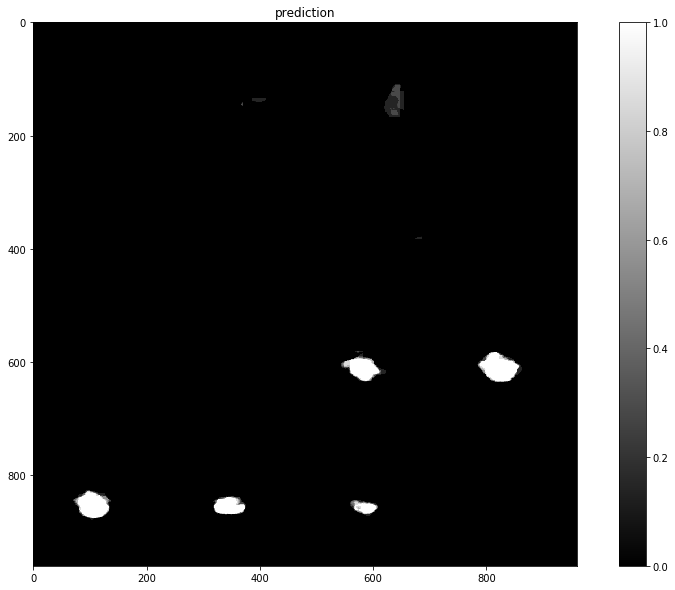

In [5]:
testing_parameters = {'inputs': ['input_data'],
               'output_filename': '_seg_predict.nii.gz',
               'batch_size': 20,
               'output_patch_shape': (64, 64, 8, 1),
               'patch_overlaps': 8,
               'output_directory': './Inference_Results',                     
               'show_output': True,
               'viz_mode_3d': 'mosaic'}

prediction = PatchesInference(**testing_parameters)

pretrained_model.clear_outputs()
pretrained_model.append_output([prediction])

figure = pretrained_model.generate_outputs(testing_data)

It's looking better! The erroneous area from earlier is now marked with a significiantly lower _pseudoprobability_, while the areas of true tumor are still bright white.

But hold on: what's _pseudoprobability_? Don't I want a binary output?

If you are working with clinicians, who by convention expect output as a yes/no map of tumor/not-tumor, then the answer is yes. Pseudoprobabilities are values ranging from 0 to 1 produced by this particular neural network. They are called "pseudo" probabilities because while they intuitively seem to correspond with a probability of a certain voxel being a tumor, they are on their own scale and cannot be literally interpeted in this way. We need some way to turn our pseudoprobability map into a binary labelmap.

Luckily, DeepNeuro has us covered. With DeepNeuro, you can add a PostProcessor object to your output to _binarize_ your output based on a certain threshold of pseudoprobability. We'll set our threshold to .95, and see what the output looks like.

('Working on image.. ', 0, 'at', '/home/abeers/Github/DeepNeuro/notebooks/Sample_Data/GBM_NIFTI/TESTING/TCGA-12-1094')
('Predicting patch set', '1/8...')
('Predicting patch set', '2/8...')
('Predicting patch set', '3/8...')
('Predicting patch set', '4/8...')
('Predicting patch set', '5/8...')
('Predicting patch set', '6/8...')
('Predicting patch set', '7/8...')
('Predicting patch set', '8/8...')


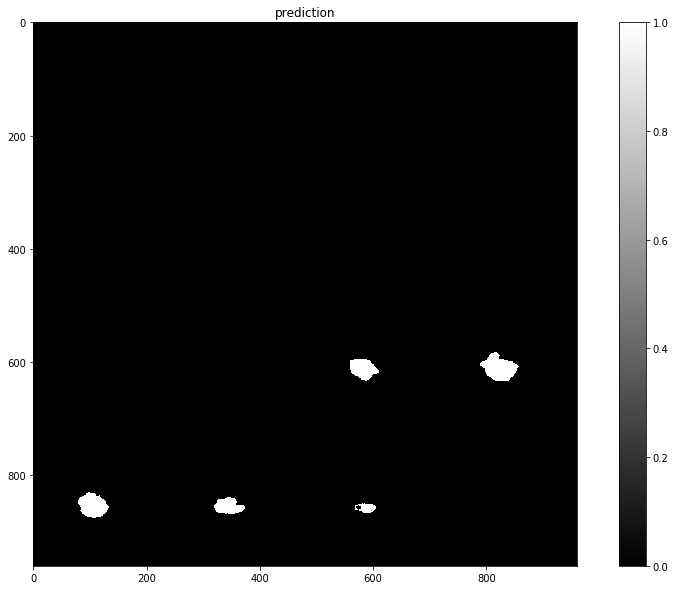

In [6]:
from deepneuro.postprocessing import BinarizeLabel

testing_parameters = {'inputs': ['input_data'],
               'output_filename': '_seg_predict.nii.gz',
               'batch_size': 20,
               'output_patch_shape': (64, 64, 8, 1),
               'patch_overlaps': 8,
               'output_directory': './Inference_Results',
                      
               'show_output': True,
               'viz_mode_3d': 'mosaic'}

prediction = PatchesInference(**testing_parameters)

label_binarization = BinarizeLabel(binarization_threshold=.95)
prediction.append_postprocessor(label_binarization)

pretrained_model.clear_outputs()
pretrained_model.append_output([prediction])

figure = pretrained_model.generate_outputs(testing_data)

Now our segmentation is starting to look good. But _how_ good? Since we have the ground truth segmentation in this case, we can actually calculate that. The most typical score used to evaluate segmentation accuracy is the _dice coefficient_. We can calculate the dice coefficient on our post-processed data automatically in DeepNeuro by adding an ErrorCalculation postprocessor.

('Working on image.. ', 0, 'at', '/home/abeers/Github/DeepNeuro/notebooks/Sample_Data/GBM_NIFTI/TESTING/TCGA-12-1094')
('Predicting patch set', '1/8...')
('Predicting patch set', '2/8...')
('Predicting patch set', '3/8...')
('Predicting patch set', '4/8...')
('Predicting patch set', '5/8...')
('Predicting patch set', '6/8...')
('Predicting patch set', '7/8...')
('Predicting patch set', '8/8...')
('Dice Coeffecient:', 0.87008521453132)


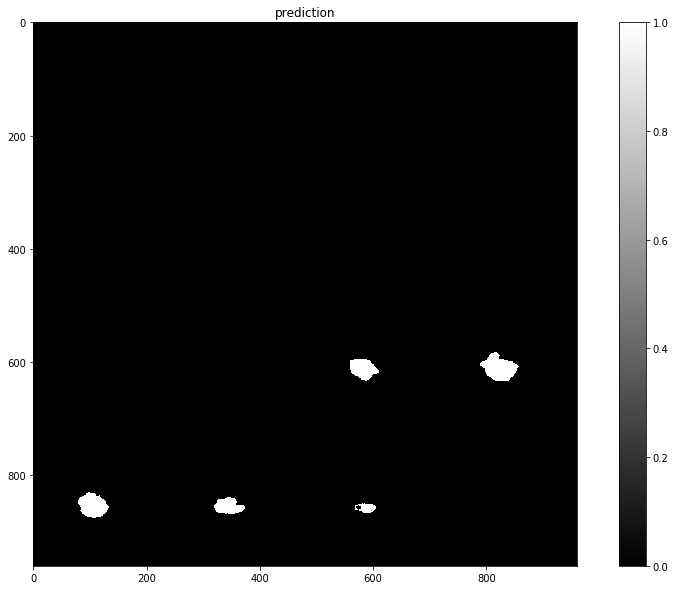

In [7]:
from deepneuro.postprocessing import ErrorCalculation

testing_parameters = {'inputs': ['input_data'],
               'output_filename': '_seg_predict.nii.gz',
               'batch_size': 20,
               'output_patch_shape': (64, 64, 8, 1),
               'patch_overlaps': 8,
               'output_directory': './Inference_Results',
                      
               'show_output': True,
               'viz_mode_3d': 'mosaic'}

prediction = PatchesInference(**testing_parameters)

label_binarization = BinarizeLabel(binarization_threshold=.95)
error_statistics_dice = ErrorCalculation(output_log='./Inference_Results/Error_Statistics.csv')
prediction.append_postprocessor([label_binarization, error_statistics_dice])

pretrained_model.clear_outputs()
pretrained_model.append_output([prediction])

figure = pretrained_model.generate_outputs(testing_data)

As far as dice coeffecients go, 0.86 is fairly high-performing, so our network seems to be working well!

So, the final step here is to save out our predictions. Luckily for you, we have been saving our predictions this whole time.

In [8]:
import os
os.listdir('./Inference_Results')

['TCGA-12-1094_seg_predict.nii.gz',
 'TCGA-12-1094_seg_predict_pseudoprobability.nii.gz',
 'Error_Statistics.csv',
 'TCGA-12-1094_seg_predict_binarized.nii.gz']